To produce the files needed to run this notebook:


 clone the CONDOR git repository
git clone https://github.com/sebouh137/condor.git;

 Follow the instructions on how to install corsika from https://gitlab.iap.kit.edu/AirShowerPhysics/corsika/-/tree/master/  Or skip the all of the corsika stuff and just use the example file 22_1000GeV.lund which is already in the directory condor/gemc, and then continue from there.  

\# Copy the modified version of corsika.cpp from the folder condor/corsika/ into corsika-work.  This contains some changes to the executable,
including additional commandline arguments that were not previously present:

cd corsika-work 
make

#note, you may have to modify these commands depending on where you installed corsika and the condor project.  
mkdir out
bin/corsika --energy 1000 --filename out/22_1000GeV --pdg 22 --nevent 10 --emcut 0.35 --hadcut 0.35
cd ~/condor/corsika
#convert the output file (parquet) from corsika to a format that can be used as input for GEMC (lund).  The elevation parameter is just 50 m above the nominal elevation of the detector.  
python parquet2lund.py --input ~/corsika-work/out/22_1000GeV/particles/particles.parquet --output ~/condor/gemc/22_1000GeV.lund --elevation 5350

\# If you skipped the stuff with corsika and are just using the example lund file, continue here.  
 pull the docker image for gemc
docker pull jeffersonlab/gemc:2.9
\# create a container with the docker image (replacing /path/to/condor with the absolute path of where you put the condor project)
docker run -it --rm -v /path/to/condor/:/condor/  -p 127.0.0.1:6080:6080 jeffersonlab/gemc:2.9
\# in your browser, enter the following address:
http://127.0.0.1:6080

\# Inside the container run the following commands
\# go to the appropriate folder:
cd /condor/gemc/
\# generates the files describing the experiments' geometry, materials, and banks descriptions
perl condor.pl config.dat
\# recompile gemc with the condor hitprocess:
./mod_and_recompile_gemc.sh

\# first run gemc on one of the LUND files from corsica, 
gemc condor.gcard -USE_GUI=0 -INPUT_GEN_FILE="LUND,22_1000GeV.lund" -OUTPUT="evio,22_1000GeV.ev"
#convert the output file to ROOT
evio2root -INPUTF="22_1000GeV.ev" -B="condor" -R="condor"

\# generate a file with muons that will be used in the MIP determination:
\# The file muons.gcard gives the settings for running gemc with its internal generator.
gemc muons.gcard -USE_GUI=0; 
\# convert this file to root
evio2root -INPUTF="muon_test.ev" -B="condor" -R="condor"


#Outside of the docker container, install the python package pylandau through pip (requires Python 3.10 or higher).  
pip install pylandau

\# Then you will have all the files you need for running this notebook

In [3]:
import ROOT
import numpy as np, pandas as pd
import matplotlib.pylab as plt
plt.rcParams["figure.figsize"] = [7.00, 7.00]
plt.rcParams["figure.autolayout"] = True
plt.set_cmap("viridis")

#presets for plot style
rc = plt.rc
rc('text', usetex=False)
import matplotlib as mpl
rc('font', family='serif')
rc('text', usetex=False)
rc('font', size=18)
rc('xtick', labelsize=18)
rc('ytick', labelsize=18)
rc('axes', labelsize=18)
rc('legend', fontsize=18)

import matplotlib.patches as patches

plt.rcParams['figure.facecolor']='white'
plt.rcParams['savefig.facecolor']='white'
plt.rcParams['savefig.bbox']='tight'

<Figure size 700x700 with 0 Axes>

In [4]:
import matplotlib
import matplotlib.cm as cm
cmap = matplotlib.cm.get_cmap('magma')
from matplotlib.patches import Rectangle

dX=8.7; dx=2; dZ=8.08; dz=.604
def drawEvent(event,title=None, MIP=1):
    fig, (ax1, ax2) = plt.subplots(1,2,figsize=(14,6.85), gridspec_kw=dict(width_ratios=[0.8,1]))
    gx=event.group_x
    gz=event.group_z
    px=event.panel_x
    py=event.panel_y
    pz=event.panel_z
    adc=event.ADC_ADC
    adc_order=event.ADC_order
    
    
    for ax in ax1, ax2:
        ax.set_xlim(-70, 70)
        ax.set_ylim(-70, 70)
        ax.set_xlabel("x [m]")
    
    ax1.set_ylabel("z [m]")
   
    for i in range(0, 14):
        for j in range(0, 14):
            if i in (0,13) and j in (3,4, 6,7,9,10) \
                or j in (0,13) and i in (3,4, 6,7,9,10)\
                or i in (1,12) or j in (1, 12):
                continue
            r=Rectangle(((i-7)*dX, (j-7)*dZ), dX,dZ, facecolor='w', edgecolor='0.8')
            ax1.add_patch(r)
            r=Rectangle(((i-7)*dX, (j-7)*dZ), dX,dZ, facecolor='w', edgecolor='0.8')
            ax2.add_patch(r)
            #print(i,j)
    
    norm=matplotlib.colors.LogNorm(vmin=1, vmax=np.max(adc))
    for i in range(0,len(gx)):
        if adc_order[i]==0:
            r=Rectangle(((gx[i]-1)*dX+(px[i]-1)*dx-7*dX, (gz[i]-1)*dZ+(pz[i]-1)*dz-7*dZ), dx,dz, facecolor=cmap(norm(adc[i])), edgecolor='none')
            if py[i]==2:
                ax1.add_patch(r)
            if py[i]==1:
                ax2.add_patch(r)
    cbar = plt.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap),ax=ax2)
    
    fig.suptitle(title)
    ax1.text(-60, -60,"ABOVE GROUND", color='0.5')
    ax2.text(-60, -60,"UNDERGROUND", color='0.5')
    ax1.invert_yaxis()
    ax2.invert_yaxis()
    cbar.set_label("energy [MIPs]")
    


3179
[102.33342483  78.01033563 419.05109459] [[ 7.17885794 -4.84357568 -2.54402287]
 [-4.84357568  7.45473694  3.89666928]
 [-2.54402287  3.89666928 13.81658733]]


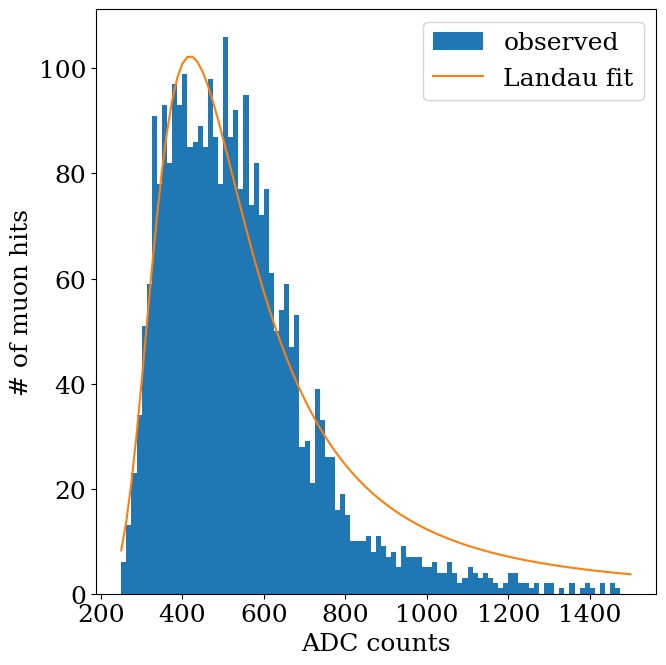

In [76]:
f= ROOT.TFile("muon_test.root")
tree=f.Get("condor")
all_adcs=[]
for event in tree:
    #all_adcs+=list(np.sqrt(np.multiply(list(event.ADC_ADC[::2]),list(event.ADC_ADC[1::2]))))
    all_adcs+=list(event.ADC_ADC[::2])
print(len(all_adcs))
y,x,_=plt.hist(all_adcs, bins=100, range=(250, 1500), label='observed')
# requires Python 3.10
# pip install pylandau
import pylandau
from scipy.optimize import curve_fit

f=lambda x,a,b,c: a*pylandau.landau((x-c)/b)
popt, pcov=curve_fit(f, (x[:-1]+x[1:])/2, y, p0=(240.62641819, 25.02595544, 450.02910595))
plt.plot(x, f(x, *popt), linestyle='-', label="Landau fit")
print(popt, pcov)
plt.xlabel("ADC counts")

plt.ylabel("# of muon hits")

plt.legend()
plt.show()
MIPS_from_muons = popt[2]
#help(curve_fit)


In [71]:
# f= ROOT.TFile("muon_test.root")
# tree=f.Get("condor")
# all_adcs=[]
# for event in tree:
#     all_adcs+=list(np.sqrt(np.multiply(list(event.ADC_ADC[::2]),list(event.ADC_ADC[1::2]))))
#     #all_adcs+=list(event.ADC_ADC[::2])
# print(len(all_adcs))
# y,x,_=plt.hist(all_adcs, bins=100, range=(350, 1500))
# #requires Python 3.10
# #pip install pylandau
# import pylandau
# from scipy.optimize import curve_fit

# f=lambda x,a,b,c: a*pylandau.landau((x-c)/b)
# popt, pcov=curve_fit(f, (x[:-1]+x[1:])/2, y, p0=(240.62641819, 25.02595544, 450.02910595))
# plt.plot(x, f(x, *popt), linestyle='-')
# print(popt, pcov)
# plt.xlabel("$\\sqrt{ADCL*ADCR}$ counts")

# plt.ylabel("hits")
# plt.show()

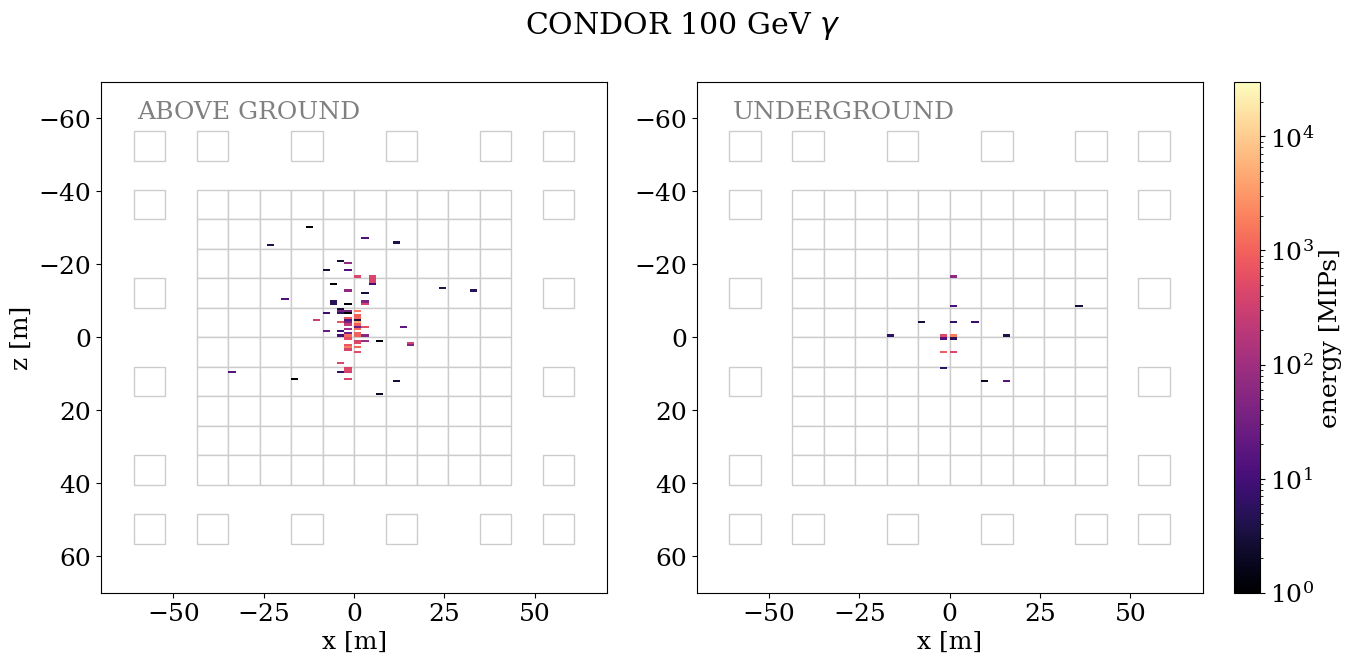

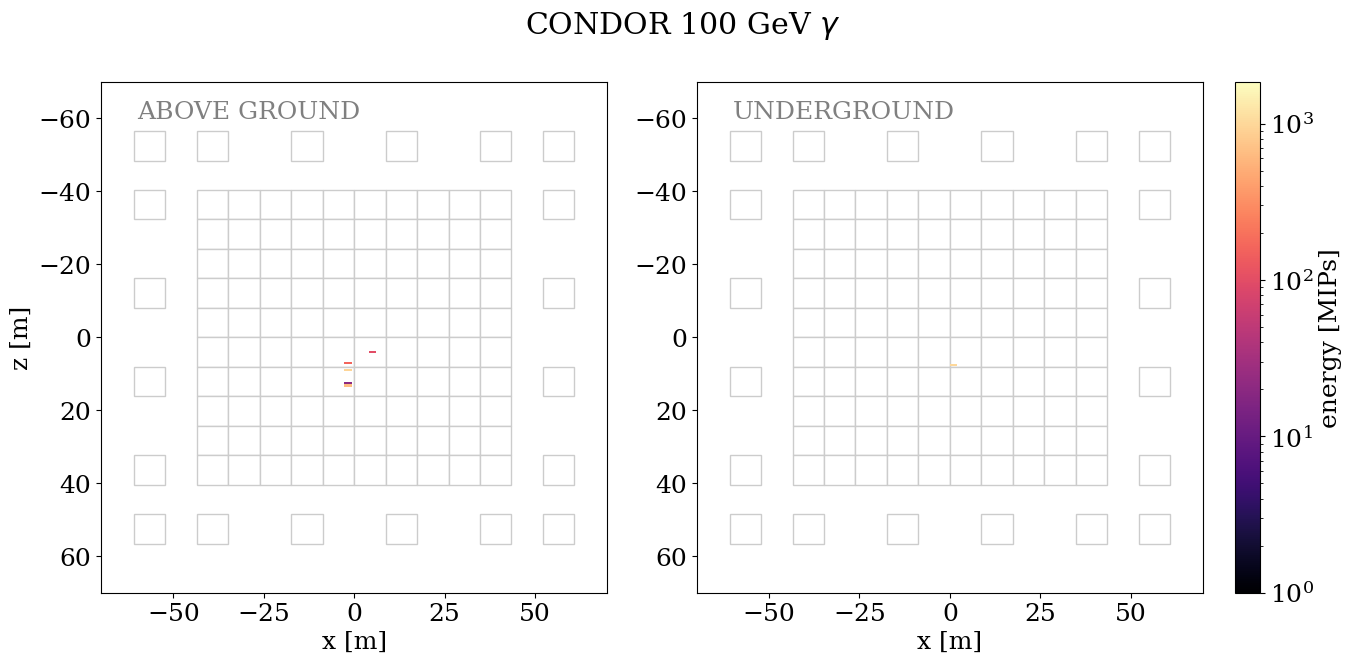

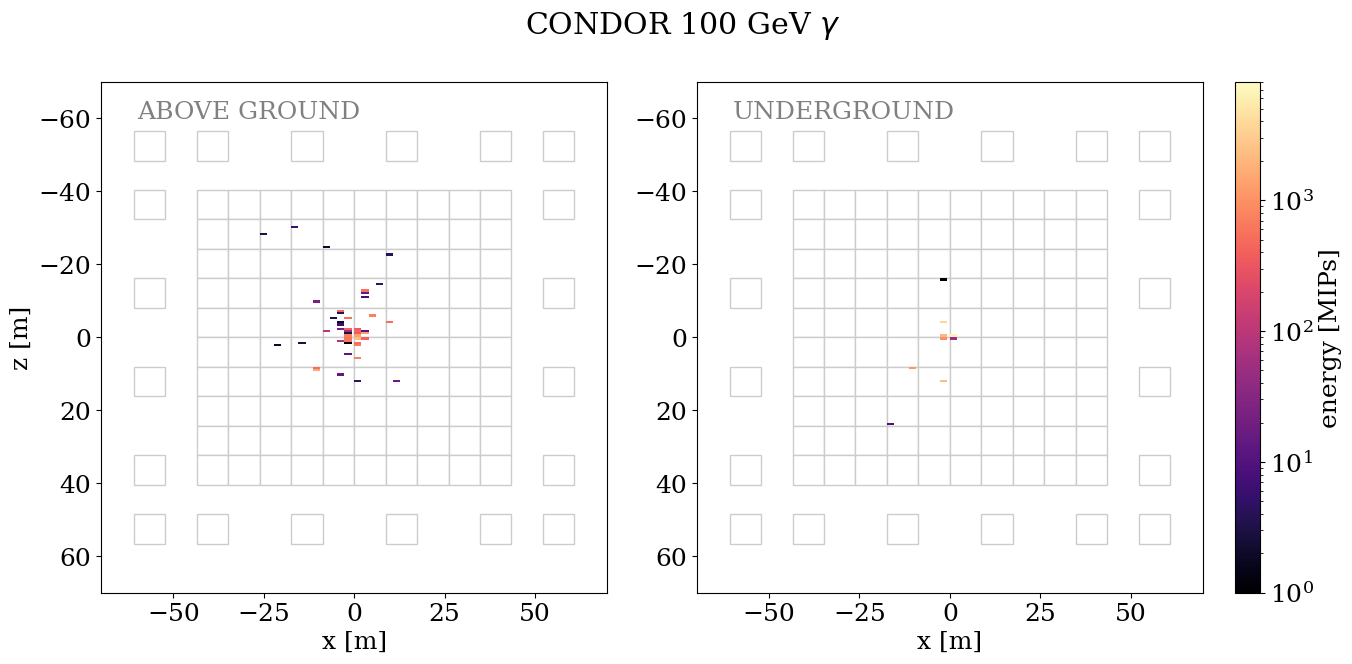

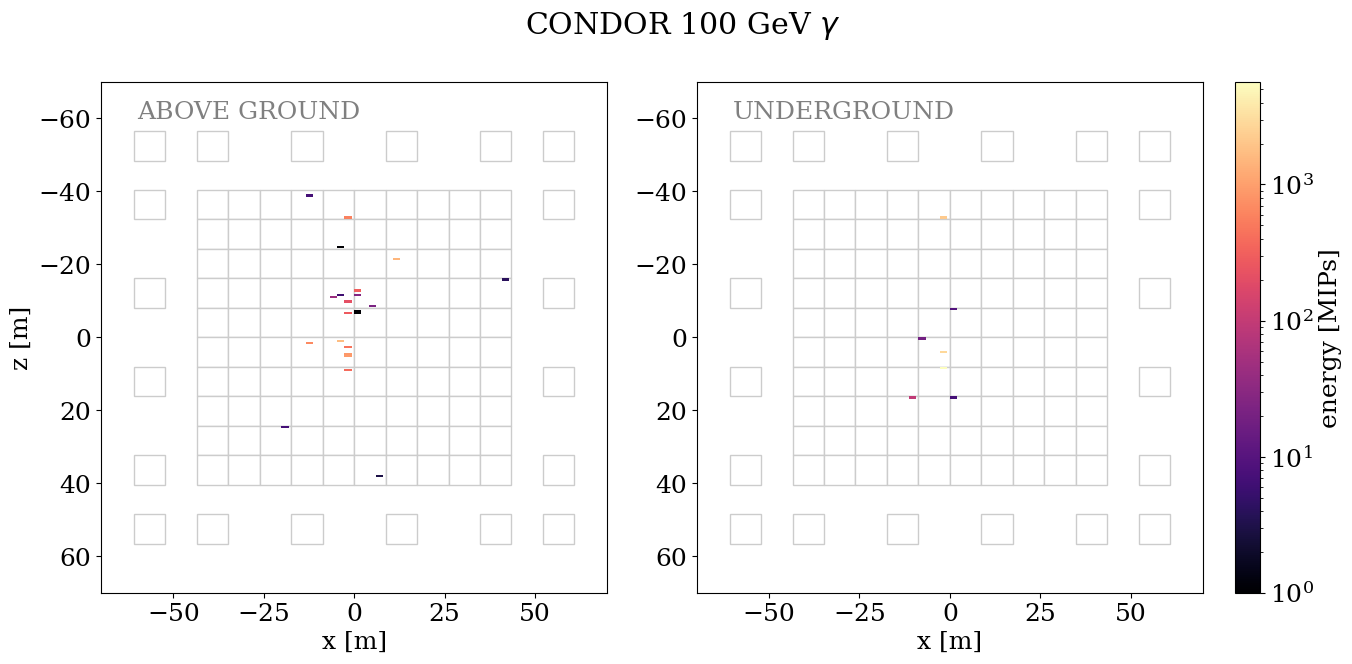

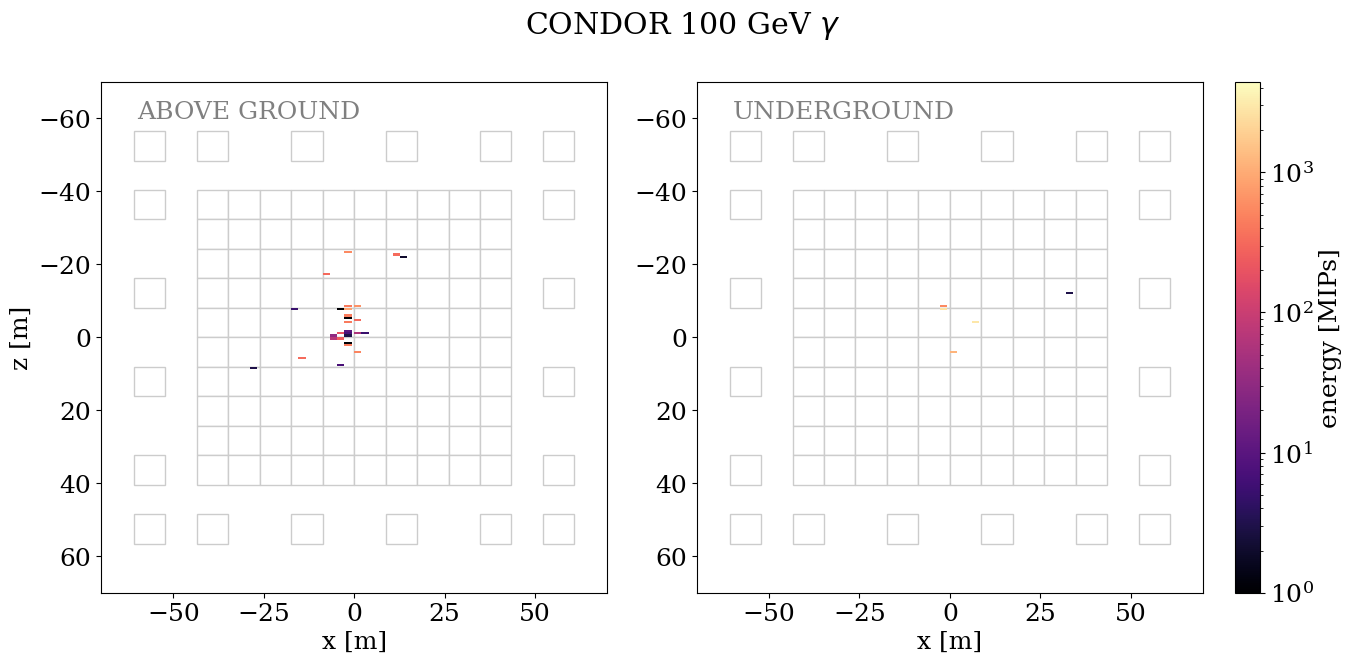

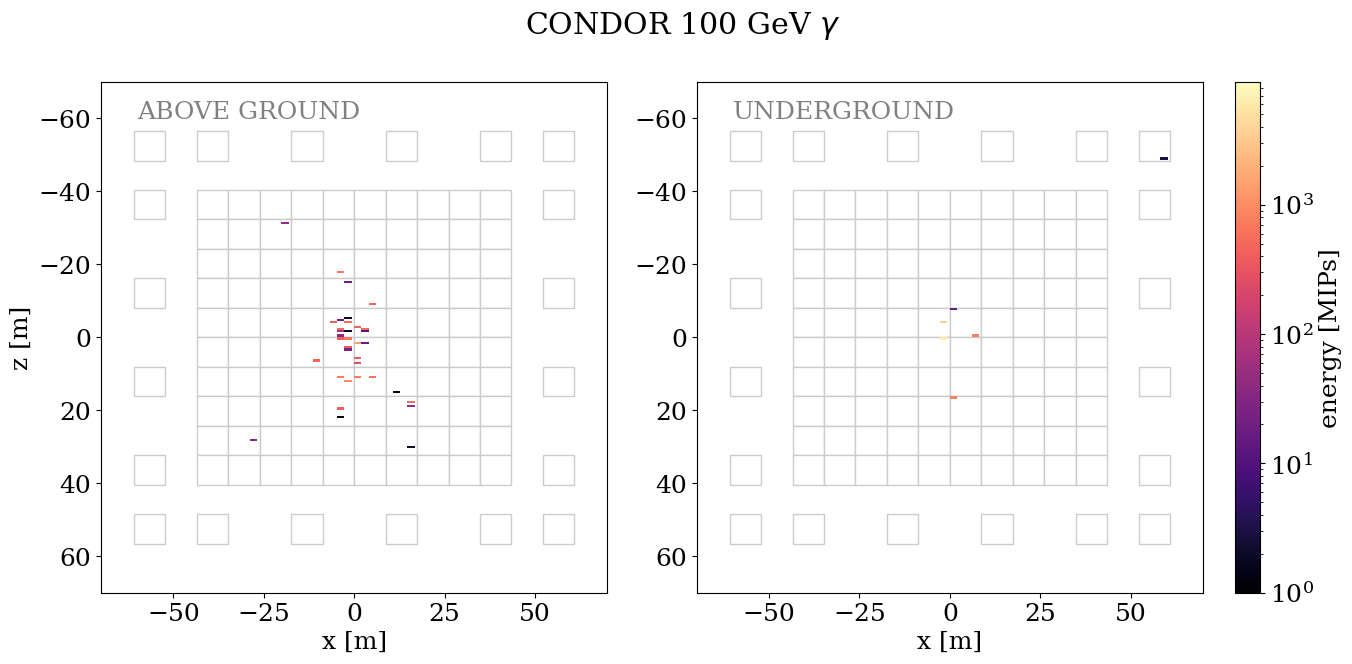

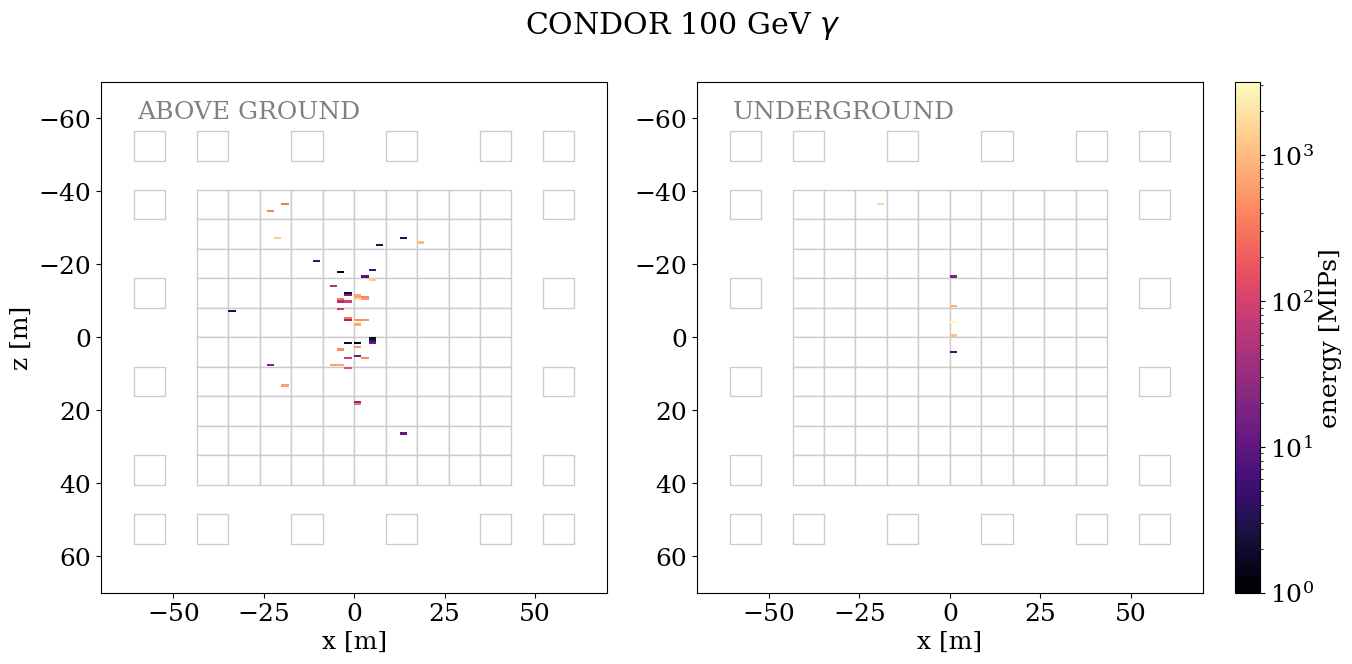

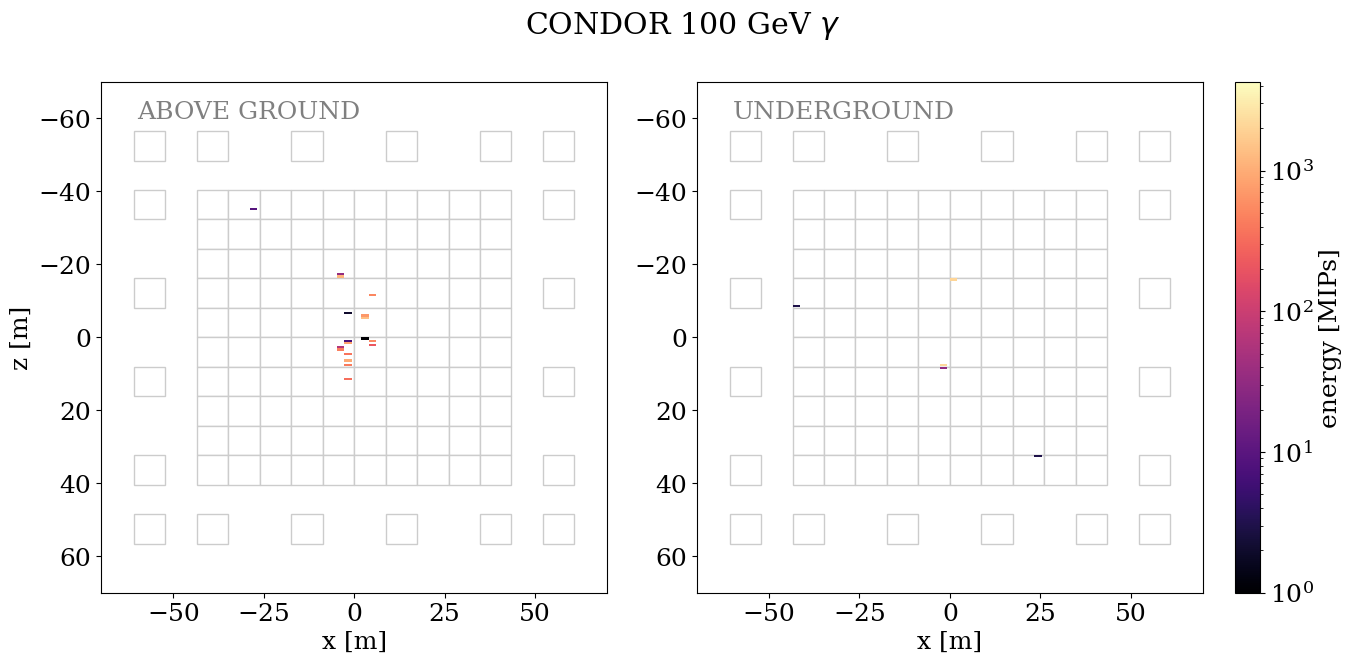

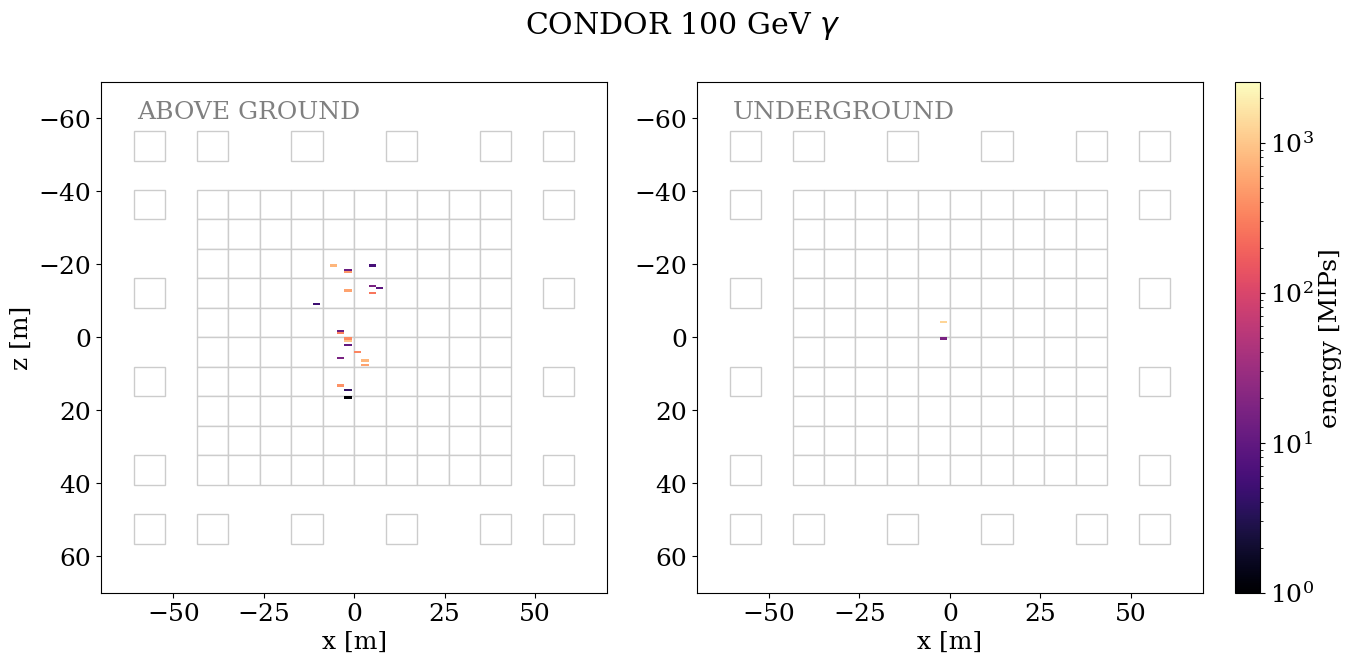

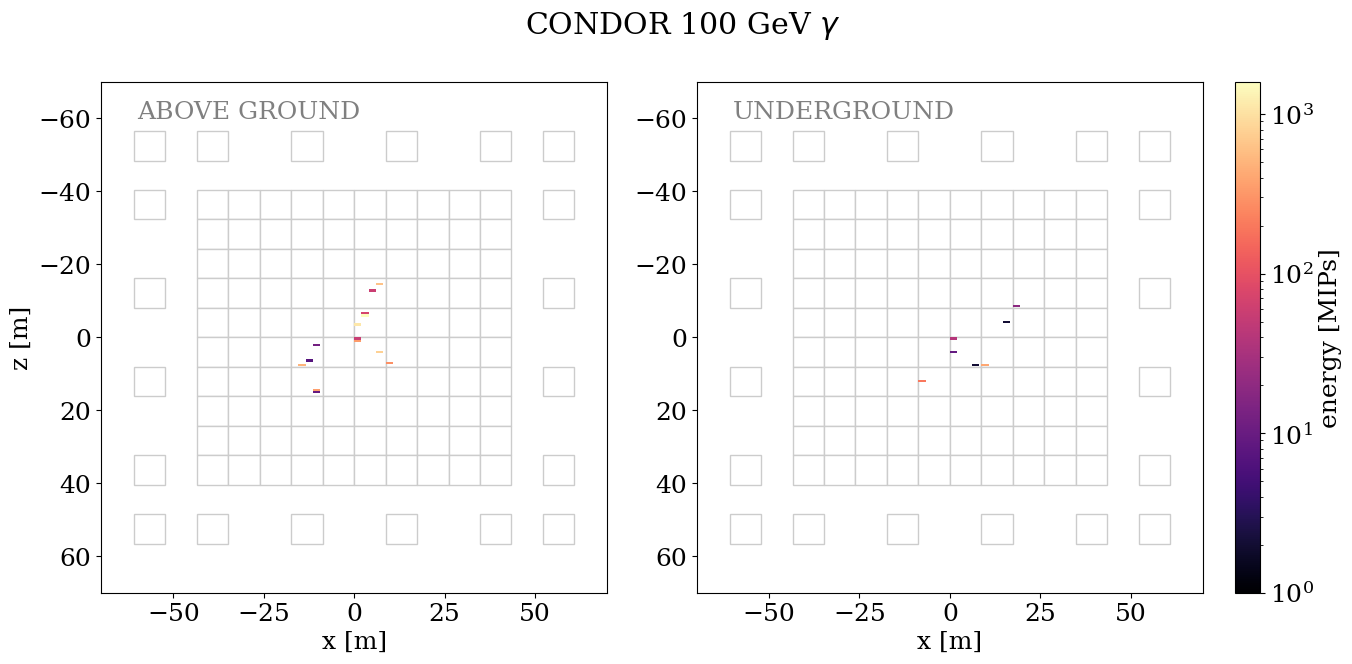

In [73]:
f= ROOT.TFile("22_1000GeV.root")
tree=f.Get("condor")
for event in tree:
    #plt.scatter((np.multiply(event.group_x,13)+event.panel_x)/13, (np.multiply(event.group_y,4)+event.panel_z)/4,c=event.ADC_ADC)
    drawEvent(event, "CONDOR 100 GeV $\\gamma$", MIP=MIPS_from_muons)
    plt.show()